# Predict ED_dispo with result from Lbl2TransformerVec and without

For architecture and weight initialization, we will compare:

• BERT (baseline)

• BioBERT

• Clinical BioBERT

• BlueBERT

• XLNet (baseline)

• Clinical XLnet

In [1]:
#!pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import gc
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import re
import tensorflow as tf
from transformers import TFXLNetModel, XLNetTokenizer
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import ParameterSampler
import json
import csv 

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import mlflow
import mlflow.keras

2023-03-10 16:46:32.337664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 16:46:33.009796: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 16:46:35.274163: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/cuda/efa/lib:/usr/local/cuda

In [3]:
#!pip install mlflow
#!databricks configure --host https://community.cloud.databricks.com/

In [2]:
%env  DATABRICKS_USERNAME= 'karengar@stanford.edu' 
%env  DATABRICKS_PASSWORD = 'Projectcs224*'

env: DATABRICKS_USERNAME='karengar@stanford.edu'
env: DATABRICKS_PASSWORD='Projectcs224*'


 - Import data

In [18]:
data_test = pd.read_csv('/root/data/ed_test.csv')
data_train = pd.read_csv('/root/data/ed_train.csv')
data_val = pd.read_csv('/root/data/ed_val.csv')
data_val.head()

,Unnamed: 0,CSN,Rads_order_ID,Study,Impression,ED_dispo
0,80343,131318610796,755426017,XR ELBOW 3 VIEWS LEFT,1. No displaced fracture or traumatic malalig...,Discharge
1,66645,131314132694,741821327,XR CHEST 1 VIEW,1. Apparent retrocardiac opacity favored to b...,Admit to Inpatient
2,76374,131317332223,751367975,XR CHEST 1 VIEW,1. No acute cardiopulmonary disease.,Discharge
3,66912,131314275465,742214156,XR CHEST 1 VIEW,1. Interval improvement in aeration of the ri...,Admit to Inpatient
4,118086,131329544269,789721134,CT HEAD WO IV CONTRAST,1. No acute intracranial abnormality. 2. Sca...,Discharge


In [6]:
#result_l2v = pd.read_csv('/root/Project-CS224N-ED-Disposition/result_l2v_v1.csv') 
#result_l2v.head()

In [4]:
def evaluate(y_test, y_pred, mlflow, labelencoder, split_type):
    """
    Evaluation function. For each of the text in evaluation data, it reads the score from
    the predictions made. And based on this, it calculates the values of
    True positive, True negative, False positive, and False negative.

    :param y_test: true labels
    :param y_pred: predicted labels
    :param labels: list of possible labels
    :return: evaluation metrics for classification like, precision, recall, and f_score
    """
     
    y_pred = [round(i[0]) for i in y_pred]
    print(y_pred)
    y_test = [i for i in y_test] 

    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    mauc = auc(fpr, tpr)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    best_trhold =thresholds[ix]

    y_pred = labelencoder.inverse_transform(y_pred)
    y_test = labelencoder.inverse_transform(y_test)
    labels = list(set( y_pred + y_test))
    labels = sorted(labels)
    confusion = confusion_matrix(y_test, y_pred)

    # importing accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average= None)
    recall = recall_score(y_test, y_pred, average= None)
    f1score = f1_score(y_test, y_pred, average= None)
    
    
    report = classification_report(y_test, y_pred, target_names = labels)
    print(report)
    f_name = 'report_ '+ split_type +'.yaml'
    mlflow.log_dict(report, f_name)
    mlflow.log_metric("auc_" + split_type, mauc) 
    mlflow.log_metric("accuracy_"+ split_type, accuracy)
   

    return accuracy, precision, recall, f1score, mauc 

def mlflow_log_parameters(parameter):
    # Log parameters
    mlflow.log_param("dropout", parameter['dropout'])
    mlflow.log_param("learning_rate", parameter['learning_rate'])
    mlflow.log_param("epochs", parameter['epochs'])
    mlflow.log_param("batch_size", parameter['batch_size'])


def get_inputs(impresions, tokenizer, max_len=120):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in impresions]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

def create_xlnet(mname, ndropout, nlr):
    """ XLNet is composed of a main block and a classification layer with dropout
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')

    # XLNet model
    print(mname)
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs)[0]

    # Classification layer with dropout for regularization
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    doc_encoding = tf.keras.layers.Dropout(ndropout)(doc_encoding)
    outputs = tf.keras.layers.Dense(1, activation='relu', name='outputs')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=nlr), loss='categorical_crossentropy', 
                  metrics=[tf.keras.metrics.AUC(), 'accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model


def training_test_mae( mlflow, history):
    # Plot training and test loss at each epoch 
    fig, ax = plt.subplots()
    ax.plot(history.history['accuracy'], label='Training acc')
    plt.plot(history.history['val_accuracy'], label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    mlflow.log_figure(fig, "training_validation_accuracy.png") 

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    mlflow.log_figure(fig, "training_validation_loss.png") 

def training_Xlnet(inp_tok,y_train,  xlnet_model, ndropout, nlr, nepochs, nbatch_size, mlflow):
    xlnet = create_xlnet(xlnet_model, ndropout, nlr)
    mlflow.keras.log_model(xlnet, "Xlnet")
    history = xlnet.fit(x=inp_tok, y=y_train, epochs=nepochs, batch_size=nbatch_size, validation_split=.15)
    
    return xlnet

# Scenario 1

- Without using results from l2v

In [5]:
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/karengar@stanford.edu/XLNet_l2v")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/178009595443893', creation_time=1677703917744, experiment_id='178009595443893', last_update_time=1678446934098, lifecycle_stage='active', name='/Users/karengar@stanford.edu/XLNet_l2v', tags={'mlflow.experiment.sourceName': '/Users/karengar@stanford.edu/XLNet_l2v',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'karengar@stanford.edu',
 'mlflow.ownerId': '3913783827154434'}>

In [9]:
#data[list(result_l2v.iloc[:, 3:].columns)] = result_l2v.iloc[:, 3:]
#data.head()

In [28]:
X_train = data_train.drop(['Unnamed: 0', 'ED_dispo', 'CSN', 'Rads_order_ID'], axis=1)
X_test =  data_test.drop(['Unnamed: 0', 'ED_dispo', 'CSN', 'Rads_order_ID'], axis=1)
X_val = data_val.drop(['Unnamed: 0', 'ED_dispo', 'CSN', 'Rads_order_ID'], axis=1)


# Assigning numerical values and storing in another column
y_train =  pd.get_dummies(data_train['ED_dispo'])
y_test = pd.get_dummies(data_test['ED_dispo'])[list(y_train.columns)]
y_val =  pd.get_dummies(data_val['ED_dispo'])[list(y_train.columns)]



In [7]:
del data_train, data_test, data_val 

In [8]:
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)  

rng = np.random.RandomState(0)
param_dist = {    'dropout': [0.1,0.2, 0.3],
                  'learning_rate': loguniform.rvs(1e-6, 1e-4, size= 10),
                  'epochs': [1], #[5, 7],
                  'batch_size': [16, 32, 64]
                  }
            
dict_parameters = ParameterSampler(param_distributions=param_dist, n_iter= 1, random_state=rng)
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model) 

In [10]:
for parameter in dict_parameters:
    print(parameter)
    print('Training')

{'learning_rate': 7.387547842263903e-06, 'epochs': 1, 'dropout': 0.1, 'batch_size': 16}
Training


# Try

In [31]:

for parameter in dict_parameters:
    print(parameter)
    print('Training')
    inp_tok, ids, segments = get_inputs(X_train['Impression'], xlnet_tokenizer)
    #xlnet = training_Xlnet(inp_tok, y_train, xlnet_model, parameter['dropout'], parameter['learning_rate'], parameter['epochs'], parameter['batch_size'], mlflow)
    #xlnet = create_xlnet(xlnet_model, ndropout, nlr)
    
    print('Define token ids as inputs')
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')

    # XLNet model
    print(xlnet_model)
    xlnet = TFXLNetModel.from_pretrained(xlnet_model)
    xlnet_encodings = xlnet(word_inputs)[0]

    print('Classification layer with dropout for regularization')
    number_of_classes = 4
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    doc_encoding = tf.keras.layers.Dropout(parameter['dropout'])(doc_encoding)
    outputs = tf.keras.layers.Dense(number_of_classes, activation='softmax', name='outputs')(doc_encoding)

    print('Compile model')
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=parameter['learning_rate']), loss='mean_absolute_error', metrics=[tf.keras.metrics.AUC(), 'accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    #mlflow.keras.log_model(xlnet, "Xlnet")
    history = model.fit(x=inp_tok, y=y_train, epochs=parameter['epochs'], batch_size=parameter['batch_size'], validation_split=.15)
    #training_test_mae( mlflow, history)

{'learning_rate': 3.0303683293860306e-06, 'epochs': 1, 'dropout': 0.2, 'batch_size': 32}
Training
Define token ids as inputs
xlnet-base-cased


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Classification layer with dropout for regularization
Compile model


2718/2718 [==============================] - 2766s 1s/step - loss: 0.2728 - auc: 0.6364 - accuracy: 0.4545 - precision: 0.4546 - recall: 0.4545 - val_loss: 0.2739 - val_auc: 0.6347 - val_accuracy: 0.4521 - val_precision: 0.4521 - val_recall: 0.4521


In [34]:
print('Testing')
split_type = 'test'
inp_tok, ids, segments = get_inputs(X_test['Impression'], xlnet_tokenizer)
y_pred = xlnet.predict(inp_tok, verbose=True)


Testing
 74/457 [===>..........................] - ETA: 1:49

2023-03-10 18:57:13.193097: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 42.19MiB (rounded to 44236800)requested by op tfxl_net_model_2/transformer/layer_._0/rel_attn/einsum_5/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-03-10 18:57:13.193206: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-03-10 18:57:13.193220: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 108, Chunks in use: 108. 27.0KiB allocated for chunks. 27.0KiB in use in bin. 516B client-requested in use in bin.
2023-03-10 18:57:13.193229: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-03-10 18:57

ResourceExhaustedError: Graph execution error:

Detected at node 'tfxl_net_model_2/transformer/layer_._0/rel_attn/einsum_5/Einsum' defined at (most recent call last):
    File "/opt/conda/envs/l2v/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/envs/l2v/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/envs/l2v/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/envs/l2v/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/opt/conda/envs/l2v/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_11753/2864273857.py", line 4, in <module>
      y_pred = xlnet.predict(inp_tok, verbose=True)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/engine/training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
      return self(x, training=False)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1161, in run_call_with_unpacked_inputs
      """
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 1168, in call
      outputs = self.transformer(
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1161, in run_call_with_unpacked_inputs
      """
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 741, in call
      for i, layer_module in enumerate(self.layer):
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 748, in call
      outputs = layer_module(
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 378, in call
      outputs = self.rel_attn(
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 204, in call
      if g is not None:
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 305, in call
      attn_vec = self.rel_attn_core(
    File "/opt/conda/envs/l2v/lib/python3.10/site-packages/transformers/models/xlnet/modeling_tf_xlnet.py", line 141, in rel_attn_core
      bd = tf.einsum("ibnd,jbnd->ijbn", q_head + self.r_r_bias, k_head_r)
Node: 'tfxl_net_model_2/transformer/layer_._0/rel_attn/einsum_5/Einsum'
OOM when allocating tensor with shape[32,12,120,240] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node tfxl_net_model_2/transformer/layer_._0/rel_attn/einsum_5/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_118352]

In [33]:
#y_pred = [round(i[0]) for i in y_pred]
#print(y_pred)
#y_test = [i for i in y_test] 

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
mauc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_trhold =thresholds[ix]

y_pred = labelencoder.inverse_transform(y_pred)
y_test = labelencoder.inverse_transform(y_test)
labels = list(set( y_pred + y_test))
labels = sorted(labels)
confusion = confusion_matrix(y_test, y_pred)

# importing accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average= None)
recall = recall_score(y_test, y_pred, average= None)
f1score = f1_score(y_test, y_pred, average= None)


report = classification_report(y_test, y_pred, target_names = labels)
print(report)

NameError: name 'y_pred' is not defined

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'learning_rate': 1.3752540198337195e-05, 'epochs': 1, 'dropout': 0.1, 'batch_size': 16}
Training


/opt/conda/envs/l2v/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


xlnet-base-cased


2023-03-09 10:28:34.413456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 10:28:34.429844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 10:28:34.431898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 10:28:34.437467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

INFO:tensorflow:Assets written to: /tmp/tmppz4pawk8/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmppz4pawk8/model/data/model/assets
2023/03/09 10:29:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmppz4pawk8/model, flavor: tensorflow), fall back to return ['tensorflow==2.11.0']. Set logging level to DEBUG to see the full traceback.
/opt/conda/envs/l2v/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


2023-03-09 10:30:26.200930: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f38c402b1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-09 10:30:26.200965: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-03-09 10:30:26.263983: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-09 10:30:26.813420: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5435/5435 [==============================] - 2918s 530ms/step - loss: 0.6305 - auc: 0.6748 - accuracy: 0.5987 - precision: 0.6279 - recall: 0.8335 - val_loss: 0.5781 - val_auc: 0.7360 - val_accuracy: 0.6499 - val_precision: 0.6695 - val_recall: 0.8444


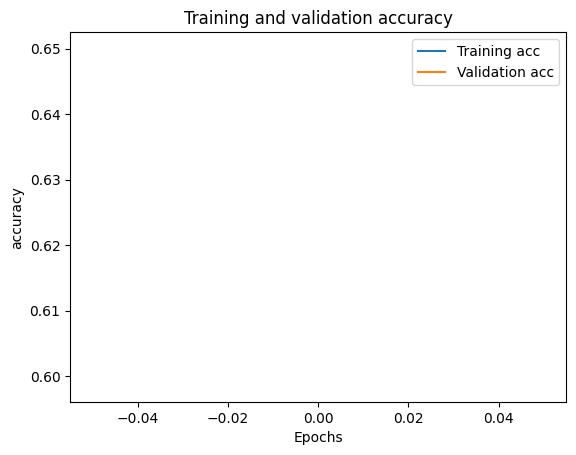

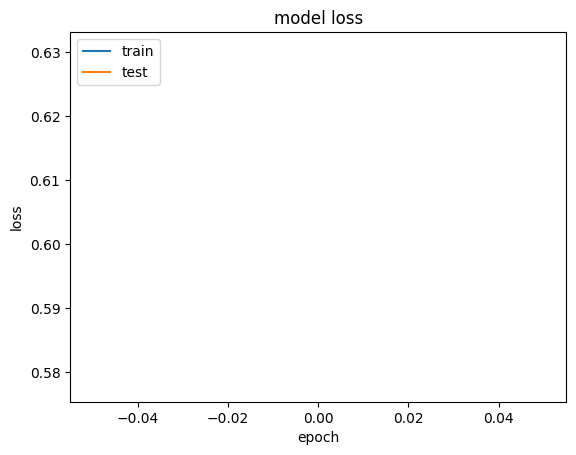

Exception: Run with UUID 25ee04f98393449a9fd33bfdb7fdd827 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

In [13]:
for parameter in dict_parameters:
    print(parameter)
    print('Training')
    inp_tok, ids, segments = get_inputs(X_train['Impression'], xlnet_tokenizer)
    xlnet = training_Xlnet(inp_tok, y_train, xlnet_model, parameter['dropout'], parameter['learning_rate'], parameter['epochs'], parameter['batch_size'], mlflow)
    with mlflow.start_run(): 
        mlflow_log_parameters(parameter) 
        print('Testing')
        split_type = 'test'
        inp_tok, ids, segments = get_inputs(X_test['Impression'], xlnet_tokenizer)
        y_pred = xlnet.predict(inp_tok, verbose=True)
        accuracy, precision, recall, f1score, mauc = evaluate(y_test, y_pred, mlflow, labelencoder, split_type)
        
        print('Validation')
        split_type = 'validation'
        inp_tok, ids, segments = get_inputs(X_val['Impression'], xlnet_tokenizer)
        y_pred = xlnet.predict(inp_tok, verbose=True)
        accuracy, precision, recall, f1score, mauc = evaluate(y_val, y_pred, mlflow, labelencoder, split_type)
        
        mlflow.end_run()

In [14]:
mlflow.end_run()

In [15]:
with mlflow.start_run(): 
        mlflow_log_parameters(parameter) 
        print('Testing')
        split_type = 'test'
        inp_tok, ids, segments = get_inputs(X_test['Impression'], xlnet_tokenizer)
        y_pred = xlnet.predict(inp_tok, verbose=True)
        accuracy, precision, recall, f1score, mauc = evaluate(y_test, y_pred, mlflow, labelencoder, split_type)
        
        print('Validation')
        split_type = 'validation'
        inp_tok, ids, segments = get_inputs(X_val['Impression'], xlnet_tokenizer)
        y_pred = xlnet.predict(inp_tok, verbose=True)
        accuracy, precision, recall, f1score, mauc = evaluate(y_val, y_pred, mlflow, labelencoder, split_type)
        
        mlflow.end_run()

Testing


/opt/conda/envs/l2v/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


457/457 [==============================] - 142s 307ms/step
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1

/opt/conda/envs/l2v/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Number of classes, 4, does not match size of target_names, 8. Try specifying the labels parameter

In [19]:
set(y_test)

{0, 1, 2, 3}

In [23]:
set([round(i[0]) for i in y_pred])
    

{0, 1}